In [36]:
include("../../datatools.jl")
using LinearAlgebra, Plots, CSV, DataFrames, Optim, DataStructures, Statistics, Polynomials

In [3]:
all_dfs = get_all_dataframes();


foreach(println, names(all_dfs["Gale/East"][1]))

time
seconds_elapsed
bearingAccuracy
speedAccuracy
verticalAccuracy
horizontalAccuracy
speed
bearing
altitude
longitude
latitude


In [4]:
df = stack_all_streets(all_dfs);


In [5]:
#Gale/East DataFrame
gedf = stack_df_vectors(all_dfs["Gale/East"])

Row,time,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude,sample
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String
1,1712673345957308200,2.23231,56.2089,1.93259,6.45663,6.432,1.51714,257.515,4.87117,-82.3503,29.6449,Sample 1
2,1712673346953398500,3.2284,37.5656,1.85054,6.44173,5.896,2.38222,247.206,5.05098,-82.3503,29.6449,Sample 1
3,1712673347951245800,4.22625,29.1882,3.3669,6.4509,5.717,4.23348,222.953,5.07378,-82.3504,29.6448,Sample 1
4,1712673348949596700,5.2246,48.6896,2.6411,6.46088,5.628,3.44796,227.991,5.38782,-82.3504,29.6447,Sample 1
5,1712673349951116800,6.22612,69.3095,2.68419,6.4709,5.574,2.20197,215.565,5.38782,-82.3504,29.6447,Sample 1
6,1712673350959734000,7.23473,58.7006,1.45248,6.48098,5.36,1.16265,198.144,5.13709,-82.3504,29.6447,Sample 1
7,1712673351959546400,8.23455,28.5719,1.7184,6.49098,5.36,2.05023,174.441,5.13354,-82.3504,29.6447,Sample 1
8,1712673352957081000,9.23208,26.3722,0.851469,5.84409,5.36,1.40228,174.722,4.67813,-82.3503,29.6447,Sample 1
9,1712673353950147600,10.2251,28.6468,0.905538,5.59612,5.36,1.3562,188.953,4.46843,-82.3503,29.6446,Sample 1


In [7]:
function fit_model_to_data(xs, ys, model_func, initial_params; n=100)

     # make sure input coordinates are scaled !!

     train_xs, train_ys = get_spaced_nodes(xs, ys, n)

     function loss(params)
          predicted_y = model_func(train_xs, params...)
          return sum((train_ys - predicted_y).^2)
     end

     opt_res = optimize(loss, initial_params)
     opt_params = Optim.minimizer(opt_res)

     fitted_ys = model_func(xs, opt_params)

     temp = DataFrame(latitude=xs, altitude=fitted_ys)
     sort!(temp, :altitude)

     return temp

end

fit_model_to_data (generic function with 1 method)

In [8]:
# test functions

function gompertz(x, a, b, c, d)
     e = exp(1)
     return @. (a * e^(b*e^(-c*x)) + d)
end

function expo(xs, a, b, c)
     return  @. a * exp(b * xs) + c 
end

function sigmoid(x, a, b, c)
     res = @. c / (1.0 + exp(-a * (x-b)))
     return res
end

sigmoid (generic function with 1 method)

In [9]:
function ridge_regression_expo(xs, ys, test_x, λ)
     
     # taking log(y) requires y>0

     offset = abs(minimum(ys)) + 1.0

     Y = log.(ys .+ offset)

     # design matrix
     X = hcat(ones(length(xs)), xs)

     # regularization matrix
     L = λ * I(size(X, 2))
     L[1, 1] = 0

     # ridge reg. 
     θ = inv(X' * X + L) * X' * Y

     # Predict on new data
     ln_y_pred = @. θ[1] + θ[2] .* test_x

     y_pred = exp.(ln_y_pred) .- offset 

     # package up into easy to use form 
     temp = DataFrame(latitude=test_x, altitude=y_pred)
     sort!(temp, :latitude)

     return temp

end

ridge_regression_expo (generic function with 1 method)

In [10]:
function find_best_lambdas(ridge_function, ridge_params, ys; eval_size=1000, num_lambdas=5, step_size=1)
     results = []
     n=eval_size

     for i = 0:step_size:n
          ft = ridge_function(ridge_params..., float(i))
          x = ft.latitude
          y = ft.altitude

          diff = sqrt(mean((ys - y) .^2))

          push!(results, (lambda=float(i), rmse=diff))
     end

     best = nsmallest(num_lambdas, results, by=x->x.rmse)

     return best

end

find_best_lambdas (generic function with 1 method)

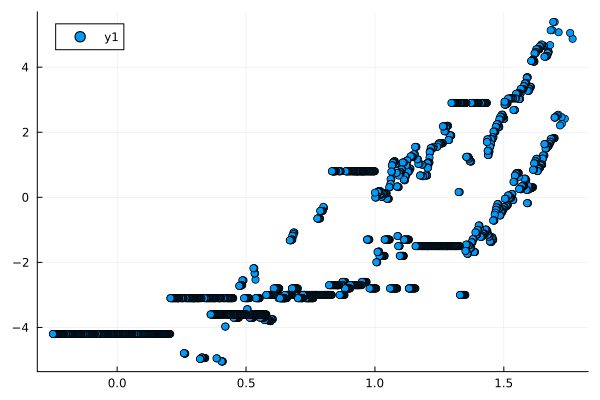

In [11]:
scaled_gedf = scale_coordinates(gedf)

xs = scaled_gedf.latitude;
ys = scaled_gedf.altitude;

scatter(xs, ys)

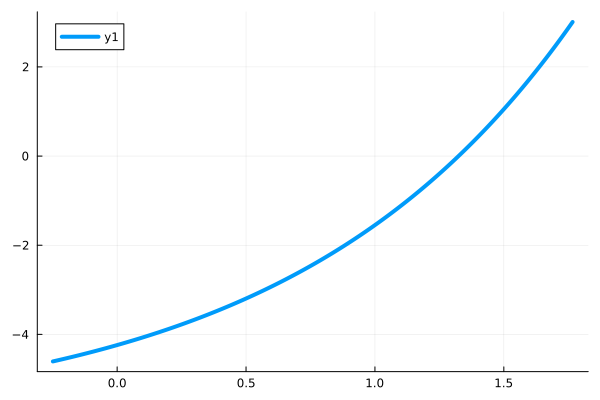

In [12]:
test_x = collect(range(minimum(xs), maximum(xs), length(xs)));

ft = ridge_regression_expo(xs, ys, test_x, 1.0)

# scatter(xs, ys)
plot(ft.latitude, ft.altitude, lw=4)

In [13]:
find_best_lambdas(ridge_regression_expo, [xs, ys, test_x], ys; eval_size=100)

5-element Vector{Any}:
 (lambda = 100.0, rmse = 3.741170464775484)
 (lambda = 99.0, rmse = 3.743166878459722)
 (lambda = 98.0, rmse = 3.745170182142426)
 (lambda = 97.0, rmse = 3.747180412877697)
 (lambda = 96.0, rmse = 3.7491976079885276)

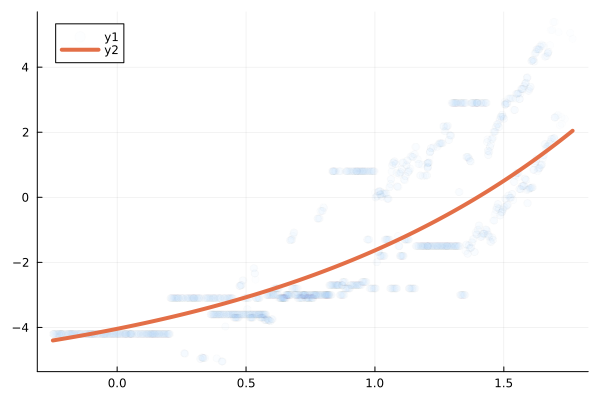

In [14]:
ft = ridge_regression_expo(xs, ys, test_x, 100.)
scatter(xs, ys, ma=0.01)
plot!(ft.latitude, ft.altitude, lw=4)


$y = ae^{kx}$

$ln(y) = ln(a) + kx$

look at the objective instead of rmse

||y -Xc|| - \lambda ||c||2

Fix lam, optim c
Fix c, optim lam

In [50]:
xs = collect(0:0.5:20)
ys = tanh.(xs) + randn(length(xs)) / 25

rdm(xs) = xs^2
rdm2(xs) = sin(xs)
rdm3(xs) = cos(xs) + sin(xs)

M = @. [rdm(xs)^0 rdm(xs) rdm2(xs) rdm3(xs)]

results = []

for i in 1:size(M, 2)
     A = M[:, i]
     X = A \ ys
     push!(results, X)
end

results

4-element Vector{Any}:
 0.9614788434880522
 0.00409593644871617
 0.05463854754504742
 0.04859923494669485

In [47]:
# scatter(xs, ys)


In [48]:
s = Polynomial(results[2])

Polynomial(-5.113273871877392e-5)

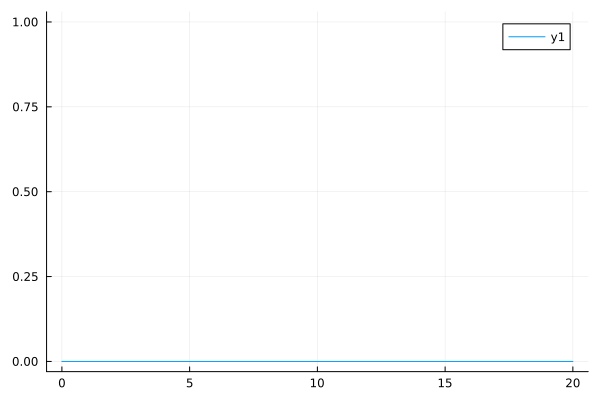

In [49]:
plot(xs, s.(xs))